## Ethena Price Drivers

Key Questions
1) General understanding of Ethena
- How much of ENA price/returns can be explained by ETH price/returns?
- The supply and demand flow: 
-- What is the amount of ENA that is being claimed (and sold) on average? How much of claimed ethena has been sold?
-- What is the demand for ENA? Proxied by Pendle yields
- How has ENA liquidity been moving over time? Is it worth providing liquidity given the recent impermanent loss?
- Can we predict ENA price using the basis yield

2) Can we predict ENA price using these variables?

ETH and ENA price data has been fetched with Yahoo Finance. The Pendle yield has been fetched from the Pendle API, and Season 1 ENA claims from Dune Analytics.


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
from scipy.stats import f_oneway, kruskal
import requests
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam


import sys
import os

sys.path.append(os.path.abspath('..'))
from ena_analysis.backtest import Backtest
from utils import *


# UTILS

In [3]:
def mean_directional_accuracy(actual, predicted):
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

# Define a function to create sequences from the data
def create_sequences(data, sequence_length=1):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])
        y.append(data[i+sequence_length, -1])
    return np.array(X), np.array(y)

# DATA MANIPULATION

In [4]:
# Load data
df = pd.read_csv('data/ena_1h_data.csv')
df_daily = pd.read_csv('data/ena_1d_data.csv')

# Convert 'Datetime' columns to datetime type
df, df_daily = to_datetime(df, ['Datetime']), to_datetime(df_daily, ['Datetime'])

# Shift data and calculate changes
df = shift_data(df, ['ENA_Price', 'ENA_Returns'])
df_daily = shift_data(df_daily, ['ENA_Price', 'ENA_Returns'])

# Circulating supply dictionary
circulating_supply = {
    '2024-04-08': 1425000000, '2024-05-01': 1425000000,
    '2024-06-01': 1520312500, '2024-07-01': 1615625000, '2024-07-06': 1710937500
}

# Prepare circulating supply DataFrame
circulating_supply_df = prepare_circulating_supply(circulating_supply)

# Merge and calculate liquid supply
df_daily = merge_supply(df_daily, circulating_supply_df, 'Total_Stake')

# DATA VISUALIZATION

### How much ENA is being claimed daily?

- The amount of ENA being claimed daily has slowed down significantly, and only about ~4% of ENA remains unclaimed. This is a good sign as it means that the ENA supply will be more stable in the future.
- Addresses that received more than 1000 ENA have sold on 91% of their airdrop on average. That for sure has created a lot of selling pressure, and only 4% of the supply remains unclaimed. On the other hand, the heavy selling might indicate that people see no use case for the token.  

Text(0.5, 0, 'Date')

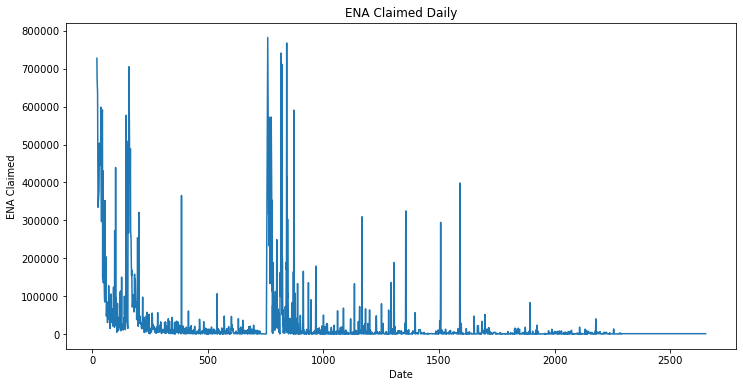

In [5]:
# plot how much ena is claimed daily, make the visualization beautiful. First drop outlier values, 99% percentile. Date as x-axis
plot_claims = df[df['claimed'] < df['claimed'].quantile(0.98)]
plot_claims['claimed'].plot(kind='line', figsize=(12, 6))
plot_claims.set_index('Datetime', inplace=True)
plt.ylabel('ENA Claimed')
plt.title('ENA Claimed Daily')
plt.xlabel('Date')

/tmp/ipykernel_321826/2822446517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_claims['claimed_pct'] =  (plot_claims['total_claimed'] / 750000000)


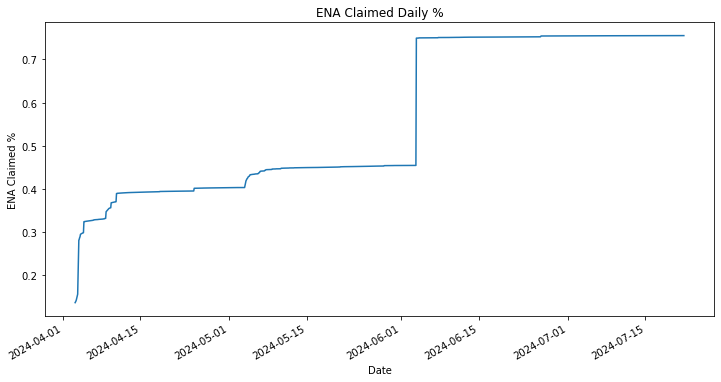

In [6]:
plot_claims['claimed_pct'] =  (plot_claims['total_claimed'] / 750000000)

# Visualize claimed_pct beautifully
plot_claims['claimed_pct'].plot(kind='line', figsize=(12, 6))
plt.ylabel('ENA Claimed %')
plt.title('ENA Claimed Daily %')
plt.xlabel('Date')
plt.show()

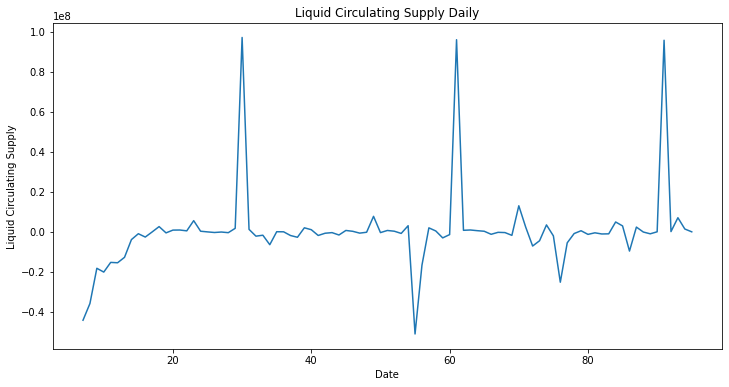

In [7]:
# plot the liquid circulating supply
df_daily['Liquid Circulating Supply Change'].plot(kind='line', figsize=(12, 6))
plt.ylabel('Liquid Circulating Supply')
plt.title('Liquid Circulating Supply Daily')
plt.xlabel('Date')
plt.show()

## Granger causality

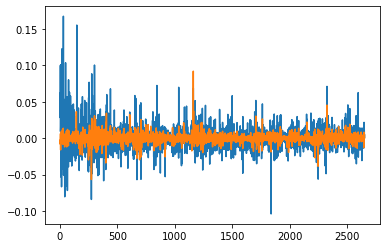

In [8]:
# Do a granger causality test on ENA price and ETH Price
from statsmodels.tsa.stattools import grangercausalitytests

ena_returns = df['ENA_Returns']
eth_returns = df['ETH_Returns']


plt.plot(ena_returns, label='ENA Price')
plt.plot(eth_returns, label='ETH Price')

granger_test_df = pd.DataFrame(data={'ENA_Returns': ena_returns, 'ETH_Returns': eth_returns})
granger_test_df.dropna(inplace=True)

In [9]:
gc_res = grangercausalitytests(granger_test_df.dropna(), 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0101  , p=0.1564  , df_denom=2649, df_num=1
ssr based chi2 test:   chi2=2.0124  , p=0.1560  , df=1
likelihood ratio test: chi2=2.0116  , p=0.1561  , df=1
parameter F test:         F=2.0101  , p=0.1564  , df_denom=2649, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2830  , p=0.2774  , df_denom=2646, df_num=2
ssr based chi2 test:   chi2=2.5708  , p=0.2765  , df=2
likelihood ratio test: chi2=2.5696  , p=0.2767  , df=2
parameter F test:         F=1.2830  , p=0.2774  , df_denom=2646, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9956  , p=0.3939  , df_denom=2643, df_num=3
ssr based chi2 test:   chi2=2.9946  , p=0.3925  , df=3
likelihood ratio test: chi2=2.9929  , p=0.3927  , df=3
parameter F test:         F=0.9956  , p=0.3939  , df_denom=2643, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8096  , p=0.

In [10]:
gc_results = grangercausalitytests(df[['ENA_Returns', 'ETH_Returns']].dropna(), maxlag=10, verbose=False)

# Extracting p-values and F-statistics
p_values = [gc_results[i+1][0]['ssr_ftest'][1] for i in range(10)]
f_stats = [gc_results[i+1][0]['ssr_ftest'][0] for i in range(10)]
lags = list(range(1, 11))

# Create a DataFrame from the extracted values
results_df = pd.DataFrame({
    'Lag': lags,
    'P-Value': p_values,
    'F-Statistic': f_stats
})


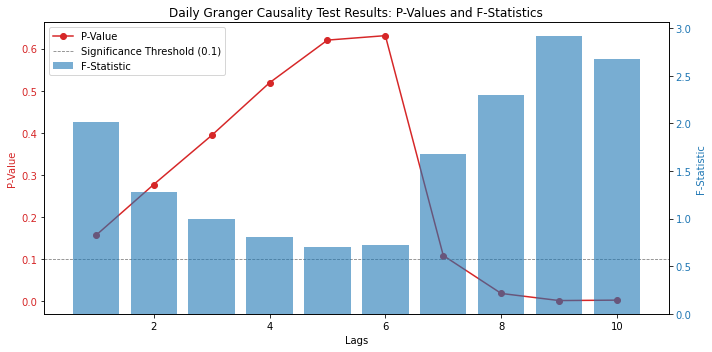

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Line plot for P-Values
color = 'tab:red'
ax1.set_xlabel('Lags')
ax1.set_ylabel('P-Value', color=color)
p_values_line, = ax1.plot(results_df['Lag'], results_df['P-Value'], color=color, marker='o', linestyle='-', label='P-Value')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0.1, color='grey', linestyle='--', linewidth=0.8, label='Significance Threshold (0.1)')  # Significance level line
ax1.set_title('Daily Granger Causality Test Results: P-Values and F-Statistics')

# Create a twin axis for the F-statistic
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('F-Statistic', color=color)
f_statistics_bar = ax2.bar(results_df['Lag'], results_df['F-Statistic'], color=color, alpha=0.6, label='F-Statistic')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a legend to the plot
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax2.legend(lines + [f_statistics_bar], labels + bar_labels, loc='upper left')

fig.tight_layout()
plt.show()


#### Results
On 1d and 4h timeframe, no significant p-values are observed even with 10 lags. On 1h timeframe, p-values start becoming signicant after 7 lags, indicating ETH returns might granger cause ENA returns.

## Cointegration test

In [12]:
# Test if ENA and ETH prices are cointegrated
from statsmodels.tsa.stattools import coint

cointegration_df = df_daily.dropna()[['ENA_Price', 'ETH_Price']]

coint(cointegration_df['ENA_Price'], cointegration_df['ETH_Price'])

(-1.5993338868743585,
 0.7211710560710322,
 array([-4.09889777, -3.44542477, -3.1196942 ]))

In [13]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test on ENA and ETH Prices
adf_ena_price = adfuller(df['ENA_Price'])
adf_eth_price = adfuller(df['ETH_Price'])

# Perform ADF Test on the Spread
spread = df['ETH_Price']- df['ENA_Price']
adf_spread = adfuller(spread)
adf_spread_2 = adfuller(df['ENA_Price'] / df['ETH_Price'])

# Print p-values
print('ADF Test Results for ENA Price:', adf_ena_price[1])
print('ADF Test Results for ETH Price:', adf_eth_price[1])
print('ADF Test Results for Spread:', adf_spread[1])
print('ADF Test Results for Spread:', adf_spread_2[1])

ADF Test Results for ENA Price: 0.6510477972983892
ADF Test Results for ETH Price: 0.3640211415025719
ADF Test Results for Spread: 0.3643186582682537
ADF Test Results for Spread: 0.7730882215838765


### Results
P-value for all time frames is about 0.9, indicating that the two time series are not cointegrated.

## Fetch funding data
- Try to get Derivative Yields data from Ethena
- Use Binance ETH funding data as a proxy for the demand for ENA

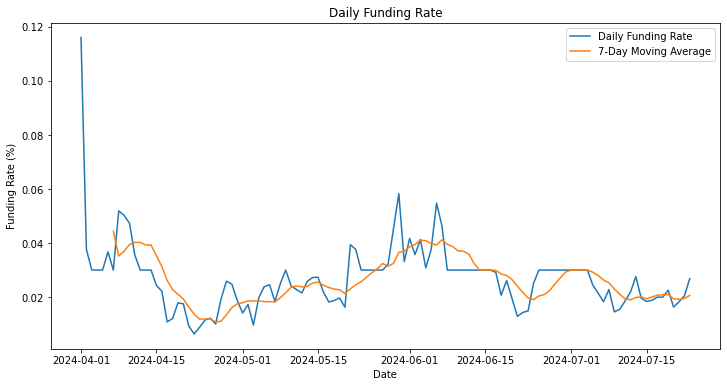

In [14]:


# Define parameters
symbol = 'ETHUSDT'  # ETH/USDT perpetual contract
start_date = '2024-04-01'  # Start date (format YYYY-MM-DD)
end_date = datetime.now().strftime('%Y-%m-%d')  # Today's date

# Fetch and process the data
funding_data = fetch_futures_funding_rates(symbol, start_date, end_date)
daily_apy = process_funding_data(funding_data)

# Plot the data
plot_daily_apy(daily_apy)

# Merge the funding data with df_daily
df_daily = df_daily.merge(daily_apy, how='left', on='Datetime')


Text(0.5, 1.0, 'Correlation Matrix Daily')

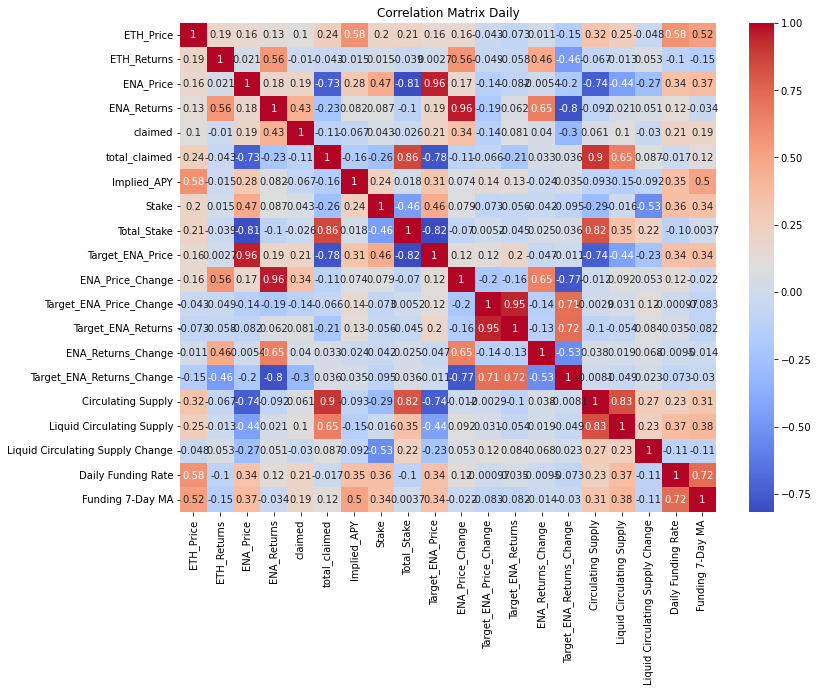

In [15]:
# Correlation matrix of df_daily, but without selected columns
correlation_matrix_daily = df_daily.corr()

# Visualize the correlation matrix with seaborn

plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix_daily, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Daily')


/tmp/ipykernel_321826/129453510.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_test['Implied_APY_Quartile'] = pd.qcut(df_daily_test['Implied_APY'], q=4, labels=False)
/tmp/ipykernel_321826/129453510.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_test['Implied_APY_Quartile'] += 1  # Shift quartiles from 0-3 to 1-4 for labeling


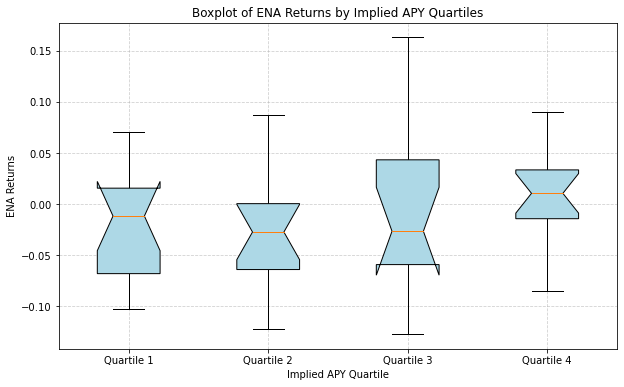

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_daily already has 'Implied_APY' and 'Target_ENA_Returns'
df_daily_test = df_daily.dropna()

# Create quartiles of 'Implied_APY'
df_daily_test['Implied_APY_Quartile'] = pd.qcut(df_daily_test['Implied_APY'], q=4, labels=False)
df_daily_test['Implied_APY_Quartile'] += 1  # Shift quartiles from 0-3 to 1-4 for labeling

# Prepare data for plotting
data_to_plot = [df_daily_test[df_daily_test['Implied_APY_Quartile'] == i]['Target_ENA_Returns'] for i in range(1, 5)]

# Create the plot
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, notch=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Adding customizations
plt.title('Boxplot of ENA Returns by Implied APY Quartiles')
plt.xlabel('Implied APY Quartile')
plt.ylabel('ENA Returns')
plt.xticks(ticks=range(1, 5), labels=[f'Quartile {i}' for i in range(1, 5)])
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [17]:
import pandas as pd
from scipy.stats import f_oneway
import numpy as np

# Assuming df_daily already has 'Implied_APY' and 'Target_ENA_Returns'
# and you have previously added the 'Implied_APY_Quartile' to df_daily as done in the previous examples.

# Group data by 'Implied_APY_Quartile'
grouped = df_daily_test.groupby('Implied_APY_Quartile')['Target_ENA_Returns']

# Extract individual groups for ANOVA
data_groups = [group for _, group in grouped]

# Perform one-way ANOVA test
anova_results = f_oneway(*data_groups)

print(f"ANOVA test results: F-statistic = {anova_results.statistic:.2f}, p-value = {anova_results.pvalue:.5f}")


ANOVA test results: F-statistic = 0.88, p-value = 0.45578


In [18]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis Test
kruskal_results = kruskal(*data_groups)

print(f"Kruskal-Wallis Test results: H-statistic = {kruskal_results.statistic:.2f}, p-value = {kruskal_results.pvalue:.5f}")


Kruskal-Wallis Test results: H-statistic = 2.74, p-value = 0.43264


## Does Basis Yield have predictibve power for ENA returns?

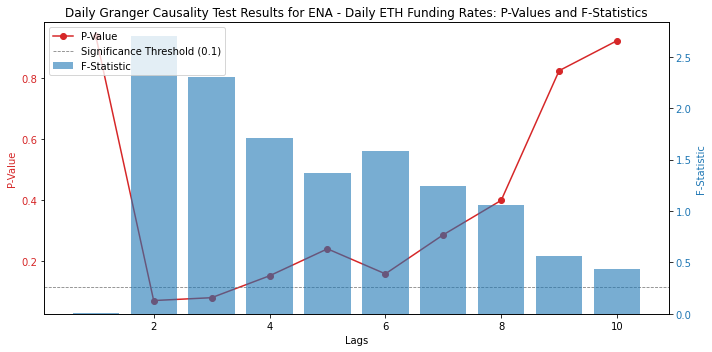

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming df_daily already has 'ENA_Returns' and 'Daily Funding Rate'
# Calculate the first difference of the Daily Funding Rate to get the change
df_daily['DFR_Change'] = df_daily['Daily Funding Rate'].diff().fillna(0)  # Using fillna(0) to handle the NA value in the first row

# Prepare the DataFrame for the Granger causality test
df_test = df_daily[['ENA_Returns', 'DFR_Change']].dropna()

# Perform Granger causality tests for 10 lags
gc_results = grangercausalitytests(df_test, maxlag=10, verbose=False)

# Extract p-values and F-statistics from the test results
results_df = pd.DataFrame({
    'Lag': range(1, 11),
    'P-Value': [gc_results[i+1][0]['ssr_ftest'][1] for i in range(10)],
    'F-Statistic': [gc_results[i+1][0]['ssr_ftest'][0] for i in range(10)]
})

fig, ax1 = plt.subplots(figsize=(10, 5))

# Line plot for P-Values
color = 'tab:red'
ax1.set_xlabel('Lags')
ax1.set_ylabel('P-Value', color=color)
p_values_line, = ax1.plot(results_df['Lag'], results_df['P-Value'], color=color, marker='o', linestyle='-', label='P-Value')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0.115, color='grey', linestyle='--', linewidth=0.8, label='Significance Threshold (0.1)')  # Significance level line
ax1.set_title('Daily Granger Causality Test Results for ENA - Daily ETH Funding Rates: P-Values and F-Statistics')

# Create a twin axis for the F-statistic
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('F-Statistic', color=color)
f_statistics_bar = ax2.bar(results_df['Lag'], results_df['F-Statistic'], color=color, alpha=0.6, label='F-Statistic')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a legend to the plot
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax2.legend(lines + [f_statistics_bar], labels + bar_labels, loc='upper left')

fig.tight_layout()
plt.show()


In [20]:
# Creating lagged versions of Basis Yield
for lag in range(1, 6):
    df_daily[f'DFR Lag: {lag}'] = df_daily['DFR_Change'].shift(lag)

# Example using a simple linear regression model to predict ENA Returns using different lags
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
results = {}
for lag in range(1, 6):
    df_temp = df_daily[['ENA_Returns', f'DFR Lag: {lag}']].dropna()
    X = df_temp[f'DFR Lag: {lag}'].values.reshape(-1, 1)
    y = df_temp['ENA_Returns']
    model.fit(X, y)
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    results[f'Lag {lag}'] = r2

print(results)


{'Lag 1': 6.832103515042043e-06, 'Lag 2': 0.04764835762905861, 'Lag 3': 0.025822873162455684, 'Lag 4': 0.001835802809061815, 'Lag 5': 0.008877899049371418}


# Baseline Models for ENA price / return prediction

SMA Model - Mean Squared Error: 0.006358600869717322
SMA Model - R^2 Score: -0.35266642347946386
SMA Model - MDA Score 0.9814814814814815


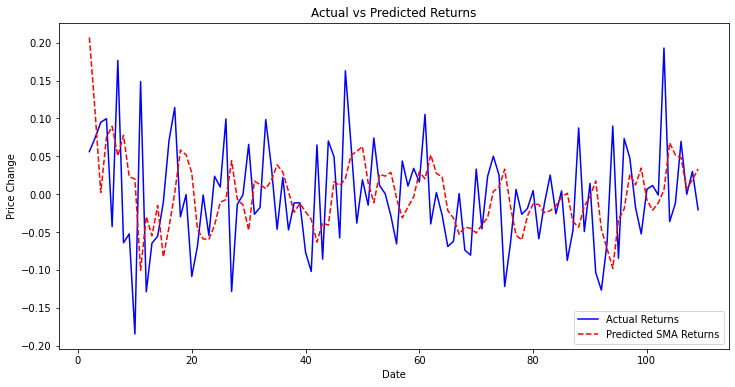

In [21]:
# Import mse

# Define the window size for SMA
window_size = 3

# Calculate the SMA for Price Change and use it to predict the next day
df_daily['SMA_Returns'] = df_daily['ENA_Returns'].rolling(window=window_size).mean()

# Drop any NaN values that were created by rolling mean calculation
df_sma= df_daily.dropna(subset=['SMA_Returns', 'Target_ENA_Returns'])

# Setting up the target and predictions
actual_price = df_sma['Target_ENA_Returns']
predicted_price = df_sma['SMA_Returns']

# Evaluate the model performance
mse_sma = mean_squared_error(actual_price, predicted_price)
r2_sma = r2_score(actual_price, predicted_price)
# Get Mean Directional Accuracy
mda_sma = mean_directional_accuracy(actual_price, predicted_price)

print("SMA Model - Mean Squared Error:", mse_sma)
print("SMA Model - R^2 Score:", r2_sma)
print("SMA Model - MDA Score", mda_sma)

# Optionally, you can plot actual vs. predicted prices for visual analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_price.index, actual_price, label='Actual Returns', color='blue')
plt.plot(predicted_price.index, predicted_price, label='Predicted SMA Returns', linestyle='--', color='red')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.legend()
plt.show()

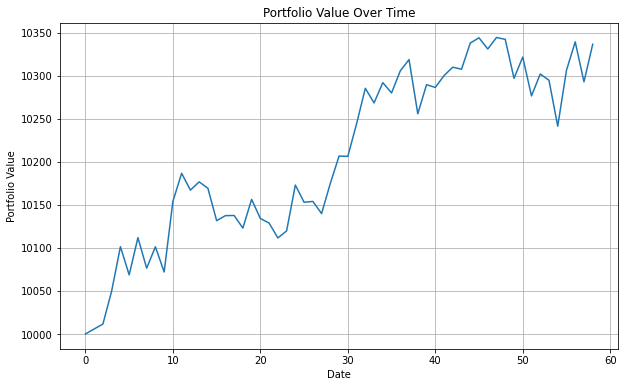

{'Win Ratio': 0.5689655172413793,
 'Buy and Hold Returns': -0.5536145932119683,
 'Strategy Total Return': 0.033653477034677914}

In [22]:
"""
# Initialize portfolio value series
"""

# Assuming df_sma already exists and has been cleaned
df_sma = df_daily.copy().dropna()
df_sma = df_sma[['ENA_Returns', 'Target_ENA_Returns', 'SMA_Returns']]
df_sma['Signal'] = np.where(df_sma['SMA_Returns'] > 0, 1, -1)

# Initial portfolio value and risk per trade
initial_portfolio_value = 10000
risk = 0.05
signals = np.array(np.sign(df_sma['Signal']))
target_r = np.array(df_sma['Target_ENA_Returns'])

sma_backtest = Backtest(signal= signals, start_val = initial_portfolio_value, risk_per_trade= risk, target_returns =target_r)
sma_cumprof, sma_total_value = sma_backtest.run_backtest()

# Plot sma_total_value
plt.figure(figsize=(10, 6))
plt.plot(sma_total_value)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

sma_backtest.get_performance_statistics()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!11 Stationarize 7-day MA, Liquid Circulating Supply, and Funding Rate
df_daily['Funding 7-Day MA'] = df_daily['Funding 7-Day MA'].diff()
df_daily['Liquid Circulating Supply'] = df_daily['Liquid Circulating Supply'].diff()
df_daily['Implied_APY'] = df_daily['Implied_APY'].diff()

df_daily.dropna(inplace=True)
# Setting up the features and target variable

predicted_variable = ['Target_ENA_Returns']
features = ['Funding 7-Day MA', 'Liquid Circulating Supply', 'Implied_APY', 'Stake', 'claimed']

# Split the data into features and target
X = df_daily[features]
y = df_daily[predicted_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting the target values for the test set
y_pred = model.predict(X_test)

y_test_flat = y_test.values.flatten()  # Flatten y_test to one dimension
y_pred_flat = y_pred.flatten()         # Flatten y_pred to one dimension

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mda = mean_directional_accuracy(y_test_flat, y_pred_flat)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("MDA Score:", mda)

# To see the importance of each feature, you can look at the coefficients
coefficients = pd.DataFrame(model.coef_.flatten(), index=features, columns=['Coefficient'])
print(coefficients.sort_values(by='Coefficient', ascending=False))

Mean Squared Error: 0.004439009599521373
R^2 Score: -0.19683357420159497
MDA Score: 0.5454545454545454
                            Coefficient
Funding 7-Day MA           4.172876e+00
Liquid Circulating Supply  1.448866e-10
claimed                   -1.552369e-10
Stake                     -3.623466e-10
Implied_APY               -6.985382e-02


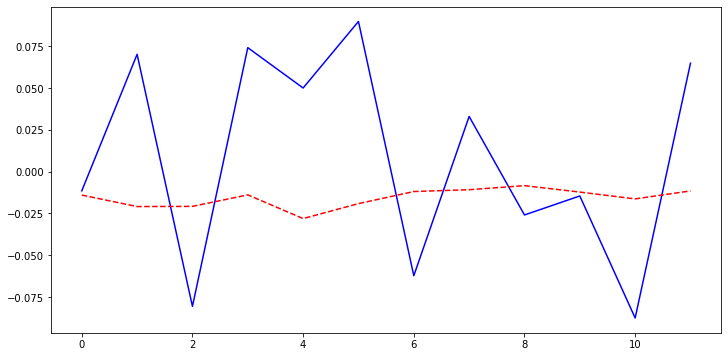

In [24]:
# plot y_Test flat and y_pred flat

plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Actual Price Change', color='blue')
plt.plot(y_pred_flat, label='Predicted Price Change', linestyle='--', color='red')

## Random Forest Regression

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define the feature sets
features_1 = ['ETH_Returns', 'ENA_Returns', 'claimed', 'Implied_APY', 'Stake', 'Total_Stake', 'Circulating Supply', 'Liquid Circulating Supply', 'Liquid Circulating Supply Change', 'Funding 7-Day MA', 'Target_ENA_Returns', 'SMA_Returns']
features_2 = ['Funding 7-Day MA', 'Implied_APY', 'Stake', 'claimed', 'Target_ENA_Returns']
features_3 = ['Funding 7-Day MA', 'Implied_APY', 'ETH_Price', 'Target_ENA_Returns']
features_4 = ['Implied_APY', 'claimed', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'Target_ENA_Returns']
features_5 = ['Stake', 'Funding 7-Day MA', 'Implied_APY', 'Target_ENA_Returns']

feature_sets = [features_2, features_3, features_4, features_5, features_1]

# Dictionary to store model performance
model_performance = {}

# Loop through each feature set
for idx, features in enumerate(feature_sets):
    random_forest_data = df_daily[features]
    random_forest_data.dropna(inplace=True)

    X = random_forest_data.drop('Target_ENA_Returns', axis=1)
    y = random_forest_data['Target_ENA_Returns']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mda = mean_directional_accuracy(y_test.values.flatten(), y_pred)

    # Store performance metrics in the dictionary
    model_performance[f"Model {idx+1}"] = {
        'Features': features,
        'MSE': mse,
        'MAE': mae,
        'MDA': mda,
        'R2': r2
    }

# Print a summary of all models' performance
for model_name, performance in model_performance.items():
    print(f"{model_name}:")
    print(f"Features: {performance['Features']}")
    print(f"Mean Squared Error: {performance['MSE']}")
    print(f"Mean Absolute Error: {performance['MAE']}")
    print('Mean Directional Accuracy:', performance['MDA'])
    print(f"R^2 Score: {performance['R2']}")
    print()


/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Model 1:
Features: ['Funding 7-Day MA', 'Implied_APY', 'Stake', 'claimed', 'Target_ENA_Returns']
Mean Squared Error: 0.0052734530748054925
Mean Absolute Error: 0.06236032192492208
Mean Directional Accuracy: 0.45454545454545453
R^2 Score: -0.4218139317798202

Model 2:
Features: ['Funding 7-Day MA', 'Implied_APY', 'ETH_Price', 'Target_ENA_Returns']
Mean Squared Error: 0.007649764551223628
Mean Absolute Error: 0.07556998185172319
Mean Directional Accuracy: 0.2727272727272727
R^2 Score: -1.0625085042908688

Model 3:
Features: ['Implied_APY', 'claimed', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'Target_ENA_Returns']
Mean Squared Error: 0.0050407116984666845
Mean Absolute Error: 0.06181793743796507
Mean Directional Accuracy: 0.36363636363636365
R^2 Score: -0.35906284123516174

Model 4:
Features: ['Stake', 'Funding 7-Day MA', 'Implied_APY', 'Target_ENA_Returns']
Mean Squared Error: 0.004725938536870204
Mean Absolute Error: 0.06019990754345372
Mean Directional Accuracy: 0.27272727272727

/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/lauri/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0.0053595411119970295
-0.44502475188236224
Implied_APY                         0.135236
Funding 7-Day MA                    0.133893
ENA_Returns                         0.130160
SMA_Returns                         0.128677
ETH_Returns                         0.122361
claimed                             0.087528
Circulating Supply                  0.082916
Liquid Circulating Supply Change    0.054244
Total_Stake                         0.051474
Liquid Circulating Supply           0.039083
Stake                               0.034430
dtype: float64


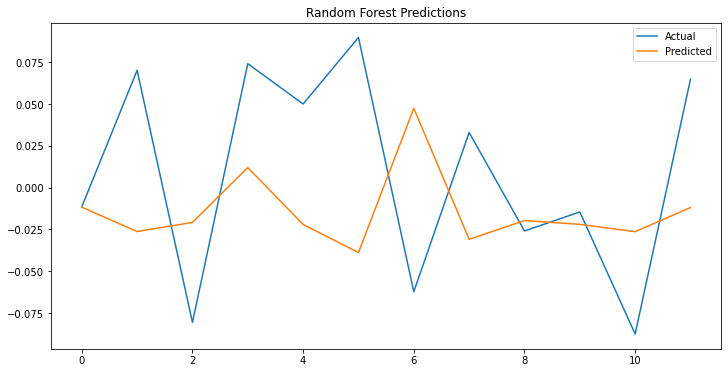

In [26]:
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error
from sklearn.metrics import mean_squared_error, r2_score
# Import grid search
from sklearn.model_selection import GridSearchCV

mse = mean_squared_error(y_test, y_pred)
print(mse)

# Print out R2
r2 = r2_score(y_test, y_pred)
print(r2)

# Print out feature importances
feature_importances = model.feature_importances_
features = X.columns
importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)
print(importances)

# Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Random Forest Predictions')
plt.show()

## LSTM

Testing ['ETH_Returns', 'Funding 7-Day MA', 'SMA_Returns'] with LR=0.01, Batch=16, Units=64
1/1 [==============================] - 1s 762ms/step
Testing ['ETH_Returns', 'Funding 7-Day MA', 'SMA_Returns'] with LR=0.01, Batch=32, Units=64
1/1 [==============================] - 1s 782ms/step
Testing ['ETH_Returns', 'Funding 7-Day MA', 'SMA_Returns'] with LR=0.01, Batch=64, Units=64
1/1 [==============================] - 1s 1s/step
Top 5 Models by MSE:
                                       Features  Learning Rate  Batch Size  \
2  [ETH_Returns, Funding 7-Day MA, SMA_Returns]           0.01          64   
1  [ETH_Returns, Funding 7-Day MA, SMA_Returns]           0.01          32   
0  [ETH_Returns, Funding 7-Day MA, SMA_Returns]           0.01          16   

   Units  Sequence length  MDA       MSE      MAPE        R2  
2     64                3  0.5  0.000467  5.372823  0.019950  
1     64                3  0.5  0.000510  5.990498 -0.071364  
0     64                3  0.5  0.000569  6.4

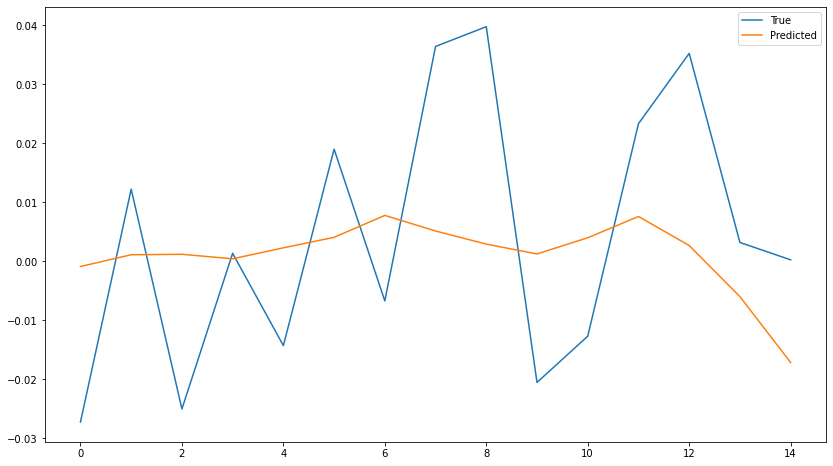

In [42]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the mean directional accuracy
def mean_directional_accuracy(actual, predicted):
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))


# Define different feature subsets
feature_sets = [
    #['ENA_Returns', 'claimed', 'Total_Stake', 'ETH_Returns', 'Implied_APY'],
    ['ETH_Returns', 'ENA_Returns', 'claimed', 'Implied_APY', 'Stake', 'Total_Stake', 'Circulating Supply', 'Liquid Circulating Supply', 'Funding 7-Day MA', 'SMA_Returns'],
    #['ETH_Returns', 'Funding 7-Day MA', 'SMA_Returns'],
    #['Stake', 'Funding 7-Day MA', 'Implied_APY', 'Daily Funding Rate', 'total_claimed'],
    #['Funding 7-Day MA', 'Implied_APY', 'Stake', 'claimed'],
    #['Stake', 'Funding 7-Day MA', 'Implied_APY']
]

# Load and preprocess data
data = df_daily

# Hyperparameters
learning_rates = [0.01]
batch_sizes = [8, 16, 32, 64]
num_units = [64, 128]
sequence_lengths = [3, 5, 7]
performance_records = []

# Convert an array of values into a dataset matrix
def create_dataset(data, sequence_length):
    X, y = [], []
    # Check if data is a DataFrame and convert to NumPy array if not already
    if isinstance(data, pd.DataFrame):
        data = data.values
    
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :-1])  # Inputs: all columns except the last
        y.append(data[i + sequence_length, -1])       # Outputs: the last column
    return np.array(X), np.array(y)

# Loop through feature sets
for features in feature_sets:
    for sequence_length in sequence_lengths:
        scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaler = MinMaxScaler(feature_range=(0, 1))    

        features_scaled = scaler.fit_transform(data[features])
        target_scaled = y_scaler.fit_transform(data[['Implied_APY']]) # Predict t+1 ENA Returns

        # Combine the scaled data and the target variable
        data_scaled = np.concatenate((features_scaled, target_scaled), axis=1)

        # Train-test split
        train_size = int(len(data_scaled) * 0.7)
        train, test = data_scaled[0:train_size, :], data_scaled[train_size:len(data_scaled), :]

        look_back = sequence_length
        X_train, y_train = create_dataset(train, look_back)
        X_test, y_test = create_dataset(test, look_back)

        # Reshape the input to be [samples, time steps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

        for lr in learning_rates:
            for batch_size in batch_sizes:
                for units in num_units:
                    print(f"Testing {features} with LR={lr}, Batch={batch_size}, Units={units}")
                    model = Sequential([
                        Bidirectional(LSTM(units, activation='tanh', return_sequences=True), input_shape=(sequence_length, X_train.shape[2])), #lookback, features
                        Dropout(0.2),
                        Bidirectional(LSTM(units, activation='relu')),
                        Dropout(0.2),
                        Dense(1)
                    ])

                    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error', metrics=['accuracy'])
                    model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_split=0.2, verbose=0)
                    
                    lstm_predictions = model.predict(X_test)
                    lstm_predictions = y_scaler.inverse_transform(lstm_predictions)  # Correct reverse transformation
                    y_test_inverted = y_scaler.inverse_transform(y_test.reshape(-1, 1))  # Correct reverse transformation

                    mda = mean_directional_accuracy(y_test_inverted.flatten(), lstm_predictions.flatten())
                    mse = mean_squared_error(y_test_inverted.flatten(), lstm_predictions.flatten())
                    mape = mean_absolute_percentage_error(y_test_inverted.flatten(), lstm_predictions.flatten())
                    r2 = r2_score(y_test_inverted.flatten(), lstm_predictions.flatten())

                    performance_records.append({
                        'Features': features,
                        'Learning Rate': lr,
                        'Batch Size': batch_size,
                        'Units': units,
                        'Sequence length': sequence_length,
                        'MDA': mda,
                        'MSE': mse,
                        'MAPE': mape,
                        'R2': r2
                    })

# Convert to DataFrame for easier manipulation
performance_df = pd.DataFrame(performance_records)

# Sort by MSE and select top 5 models
top_5_models = performance_df.sort_values(by='MSE').head(5)
print("Top 5 Models by MSE:")
print(top_5_models)

# Select the best model from top 5
best_model_index = top_5_models.index[0]
best_model_config = top_5_models.loc[best_model_index]

# Retrain the best model configuration
sequence_length = best_model_config['Sequence length']  # Ensure this is used correctly

# Plot out lstm_predictions vs actual
plt.figure(figsize=(14, 8))
plt.plot(y_test_inverted, label='True')
plt.plot(lstm_predictions, label='Predicted')
plt.legend(['True', 'Predicted'])  # Add legends
plt.show()


In [44]:
performance_df.sort_values(by='R2', ascending=False)

,Features,Learning Rate,Batch Size,Units,Sequence length,MDA,MSE,MAPE,R2
2,"[ETH_Returns, Funding 7-Day MA, SMA_Returns]",0.01,64,64,3,0.5,0.000467,5.372823,0.019950
1,"[ETH_Returns, Funding 7-Day MA, SMA_Returns]",0.01,32,64,3,0.5,0.000510,5.990498,-0.071364
0,"[ETH_Returns, Funding 7-Day MA, SMA_Returns]",0.01,16,64,3,0.5,0.000569,6.494906,-0.196000


In [45]:
performance_df.R2.mean()

-0.08247107832163736

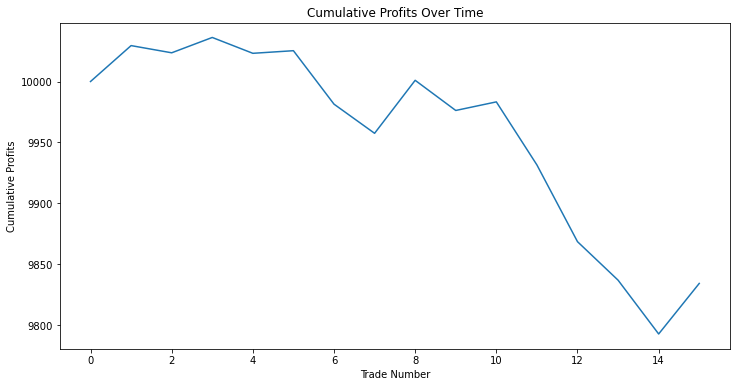

{'Win Ratio': 0.4,
 'Buy and Hold Returns': -0.3796708808561803,
 'Strategy Total Return': -0.01657788265216764}

In [46]:
backtest_folio = df_daily[-len(lstm_predictions):].reset_index()

ena_target_r = np.array(backtest_folio['Target_ENA_Returns'])
trade_signal = np.sign(lstm_predictions).reshape(-1)

lstm_backtest = Backtest(signal = trade_signal, target_returns = ena_target_r, start_val = 10000, risk_per_trade = 0.05)

profits_per_trade, cumulative_profits = lstm_backtest.run_backtest()

# Adjusting the figure size
plt.figure(figsize=(12, 6))  # Width: 12 inches, Height: 6 inches
plt.plot(cumulative_profits)
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profits')
plt.title('Cumulative Profits Over Time')
plt.show()

lstm_backtest.get_performance_statistics()

## Directionality

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 0.6807 - accuracy: 0.5833 - val_loss: 1.2192 - val_accuracy: 0.2500
Epoch 2/30
1/1 [==============================] - 0s 37ms/step - loss: 0.5063 - accuracy: 0.7500 - val_loss: 1.6159 - val_accuracy: 0.5000
Epoch 3/30
1/1 [==============================] - 0s 41ms/step - loss: 0.4608 - accuracy: 0.7500 - val_loss: 1.5916 - val_accuracy: 0.2500
Epoch 4/30
1/1 [==============================] - 0s 37ms/step - loss: 0.4723 - accuracy: 0.7500 - val_loss: 1.5109 - val_accuracy: 0.2500
Epoch 5/30
1/1 [==============================] - 0s 36ms/step - loss: 0.4303 - accuracy: 0.7500 - val_loss: 1.9024 - val_accuracy: 0.5000
Epoch 6/30
1/1 [==============================] - 0s 59ms/step - loss: 0.3912 - accuracy: 0.7500 - val_loss: 2.1546 - val_accuracy: 0.5000
Epoch 7/30
1/1 [==============================] - 0s 64ms/step - loss: 0.3464 - accuracy: 0.8333 - val_loss: 2.4097 - val_accuracy: 0.2500
Epoch 8/30
1/1 [=============

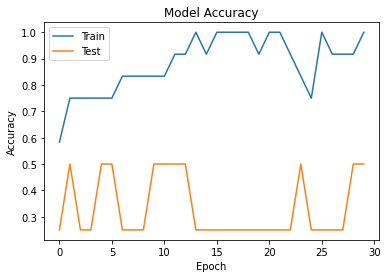

1/1 [==============================] - 1s 908ms/step
Percentage of correct direction predictions: 54.55%


In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming you have loaded your DataFrame named 'df_daily' which contains the data
# df_daily = pd.read_csv('path_to_your_data.csv')

# Define predictor variables
predictor_vars = ['ENA_Returns', 'claimed', 'Total_Stake', 'ETH_Returns', 'Implied_APY', 'SMA_Returns']

# Drop rows with missing values
df_daily = df_daily.dropna(subset=predictor_vars + ['Target_ENA_Returns'])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_daily[predictor_vars])

# Create the target variable (1 if positive return, 0 if negative)
df_daily['Positive_Target_Return'] = (df_daily['Target_ENA_Returns'] > 0).astype(int)

# Reshape data for LSTM (creating sequences)
sequence_length = 30
X = np.array([scaled_features[i - sequence_length:i] for i in range(sequence_length, len(scaled_features))])
y = df_daily['Positive_Target_Return'].values[sequence_length:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Build the LSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(sequence_length, len(predictor_vars)))),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate the Model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Make predictions
predictions = (model.predict(X_test) > 0.5).astype(int)

# Calculate the percentage of correct predictions
correct_predictions = np.sum(predictions.flatten() == y_test)
total_predictions = len(y_test)
accuracy_percentage = correct_predictions / total_predictions * 100
print(f'Percentage of correct direction predictions: {accuracy_percentage:.2f}%')
